In [1]:
 # Import libraries:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.impute import SimpleImputer

In [2]:
# Filepath
filepath = r'C:\Users\serve\OneDrive\Desktop\NFL_Big_Databowl'

# Make a list of the files
files = os.listdir(filepath)
# Make a list of dataframes
df_names = []

for file in files:
    globals()[file[:-4]] = pd.read_csv(filepath+'\\'+file)
    df_names.append(file[:-4])
# Make a list of week dataframes
weeks = [week1, week2, week3, week4, week5, week6, week7, week8]
# Concatenate weeks
df = pd.concat(weeks)


### Data Cleaning

In [3]:
# Fill the missing values with zero. When value is NA, row corresponds to ball.
df = df.dropna()
# Fill the missing college names with 'other', since dtype is object
players['collegeName'] = players['collegeName'].fillna('other')
# Fill the missing birthDates with average
players['birthDate'] = players['birthDate'].fillna(str(pd.to_datetime(
    players.birthDate, errors='coerce').mean())[0:10])
# Some variables are empty for almost all cels, so we will drop them
plays = plays.drop(columns=['penaltyYards',  'foulName1',
       'foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3'])
# We will fill the missing objectsith 'other'
plays[['yardlineSide','dropBackType','offenseFormation','personnelD','personnelO']] = plays[['yardlineSide'
                        ,'dropBackType','offenseFormation','personnelD','personnelO']].fillna('other')
# We will fill the numeric variables with zero
plays[['absoluteYardlineNumber','defendersInBox']] = plays[['absoluteYardlineNumber','defendersInBox']].fillna(0)
pffScoutingData['pff_blockType'] = pffScoutingData['pff_blockType'].fillna('other')
pffScoutingData['pff_nflIdBlockedPlayer'] = pffScoutingData['pff_nflIdBlockedPlayer'].fillna(0)
# Fill the binary outcomes with zero
pffScoutingData[['pff_hit','pff_hurry','pff_sack','pff_beatenByDefender','pff_hitAllowed'
                 ,'pff_hurryAllowed','pff_backFieldBlock','pff_sackAllowed']]\
= pffScoutingData[['pff_hit','pff_hurry','pff_sack','pff_beatenByDefender'
                   ,'pff_hitAllowed','pff_backFieldBlock','pff_hurryAllowed','pff_sackAllowed']].fillna(0)
# Merge the other dataframes:
df = df.merge(games, on='gameId', how='left')\
.merge(players, on = 'nflId', how = 'left')\
.merge(plays, on=['gameId','playId'], how='left')\
.merge(pffScoutingData, on = ['gameId','playId','nflId'], how='left')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7952692 entries, 0 to 7952691
Data columns (total 63 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   gameId                  int64  
 1   playId                  int64  
 2   nflId                   float64
 3   frameId                 int64  
 4   time                    object 
 5   jerseyNumber            float64
 6   team                    object 
 7   playDirection           object 
 8   x                       float64
 9   y                       float64
 10  s                       float64
 11  a                       float64
 12  dis                     float64
 13  o                       float64
 14  dir                     float64
 15  event                   object 
 16  season                  int64  
 17  week                    int64  
 18  gameDate                object 
 19  gameTimeEastern         object 
 20  homeTeamAbbr            object 
 21  visitorTeamAbbr         object 

In [5]:
# Add some additional features:
df['age'] = pd.to_datetime(df['gameDate']) - pd.to_datetime(df['birthDate'])
def convertTimeToNumerical(t):
    t = t.split(":")
    if len(t) == 2:
        return int(t[0]) * 60 + int(t[1])
    return int(t[0]) * 3600 + int(t[1]) * 60 + int(t[2])
df['gameClock'] = df['gameClock'].apply(convertTimeToNumerical)

df['age'] = df['age'].dt.total_seconds()/31566240
df["height"] = (df.height.str.split("-").str[0].astype(int) * 12) + (
    df.height.str.split("-").str[1].astype(int)
)

### Exploratory Data Analysis

In [12]:
def home(gameId):
    return df.loc[df.gameId == gameId,:]['homeTeamAbbr'].unique()[0]
def visitor(gameId):
    return df.loc[df.gameId == gameId,:]['visitorTeamAbbr'].unique()[0]

# This functions gives the position summary for a given game
def playmap(gameId, side): # side is either home, or visitor
    plt.figure(figsize=(12,8))
    sns.scatterplot(x='x', y='y',hue='playDirection', data=df.loc[df.gameId == gameId,:]\
                    .loc[df.team == side(gameId),:], s=10, legend = False)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('position summary for ' + str(side(gameId)) + ' team in ' +str(home(gameId)) + ' vs. ' + str(visitor(gameId)))
    plt.show()

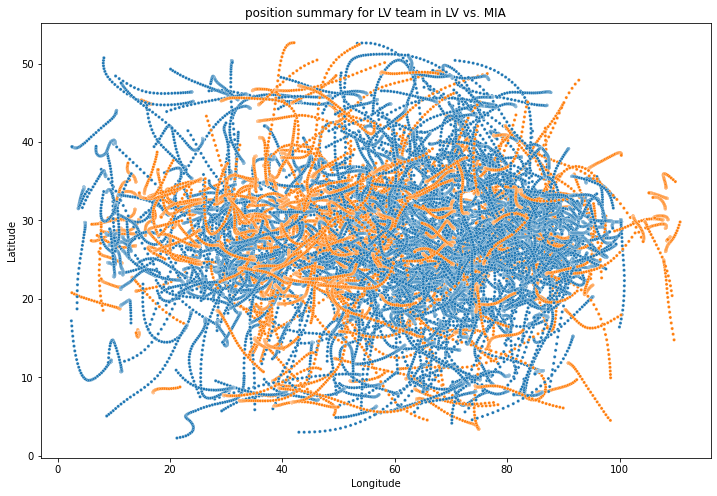

In [13]:
playmap(2021092610,home)

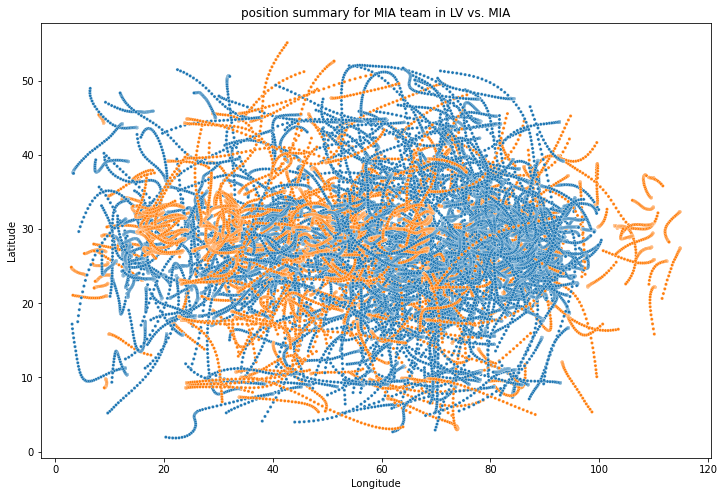

In [14]:
playmap(2021092610,visitor)

### Machine Learning

In [21]:
df[['defendersInBox','quarter','yardsToGo','gameClock','height','s']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7952692 entries, 0 to 7952691
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   defendersInBox  float64
 1   quarter         int64  
 2   yardsToGo       int64  
 3   gameClock       int64  
 4   height          int32  
 5   s               float64
dtypes: float64(2), int32(1), int64(3)
memory usage: 652.4 MB


In [22]:
xInput = df[['defendersInBox','quarter','yardsToGo','gameClock','height','s']]
yInput = df['passResult']
#split data into train and test
xTrain,xTest,yTrain,yTest = train_test_split(xInput,yInput,random_state=0,test_size=0.25)
#scaling dataset
scaler = MinMaxScaler()
xTrainScaled = scaler.fit_transform(xTrain)
xTestScaled = scaler.fit_transform(xTest)

In [23]:
#select model
model = DecisionTreeClassifier()
#train model
model.fit(xTrainScaled,yTrain)
predictions = model.predict(xTestScaled)
#observing performance metrics
accuracy = accuracy_score(yTest,predictions)*100
print("Accuracy of the model is {:.2f}%".format(accuracy))

Accuracy of the model is 96.09%
